In [13]:
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from Data.data_processing import normalize , prepare_s2p_data
from Models.NilmLstm import build_lstm1
from sklearn.model_selection import train_test_split

In [14]:

house2 = pd.read_csv("Data/CLEAN_House2.csv", index_col=0, parse_dates=True, nrows=2000000)

print(house2.shape)

(2000000, 12)


In [15]:
sequence_length = 99

house2_normalized , scalers = normalize(house2, ["Aggregate", "Appliance3"])
house2_normalized.describe()

,Aggregate,Appliance3
count,2.000000e+06,2.000000e+06
mean,1.562324e-02,2.364343e-02
std,4.183696e-02,1.393229e-01
min,0.000000e+00,0.000000e+00
25%,3.659280e-03,0.000000e+00
50%,6.342753e-03,0.000000e+00
75%,9.188860e-03,0.000000e+00
max,1.000000e+00,1.000000e+00


In [16]:
X, y = prepare_s2p_data(
    house2_normalized["Aggregate"],
    house2_normalized["Appliance3"],
    sequence_length,
    stride = 5
)

X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False, test_size=0.2)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))

In [17]:
print(X_train.shape)
print(y_train.shape)

(319984, 99, 1)
(319984, 1)


In [18]:
model = build_lstm1(input_length=sequence_length)
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs = 3, batch_size=64, validation_split=0.15, 
                    callbacks=[early_stop], shuffle=False)

Epoch 1/3
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 195s 45ms/step - loss: 0.0173 - mae: 0.0386 - val_loss: 0.0179 - val_mae: 0.0299
Epoch 2/3
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 292s 69ms/step - loss: 0.0154 - mae: 0.0358 - val_loss: 0.0194 - val_mae: 0.0375
Epoch 3/3
3295/4250 ━━━━━━━━━━━━━━━━━━━━ 1:17 81ms/step - loss: 0.0157 - mae: 0.0361

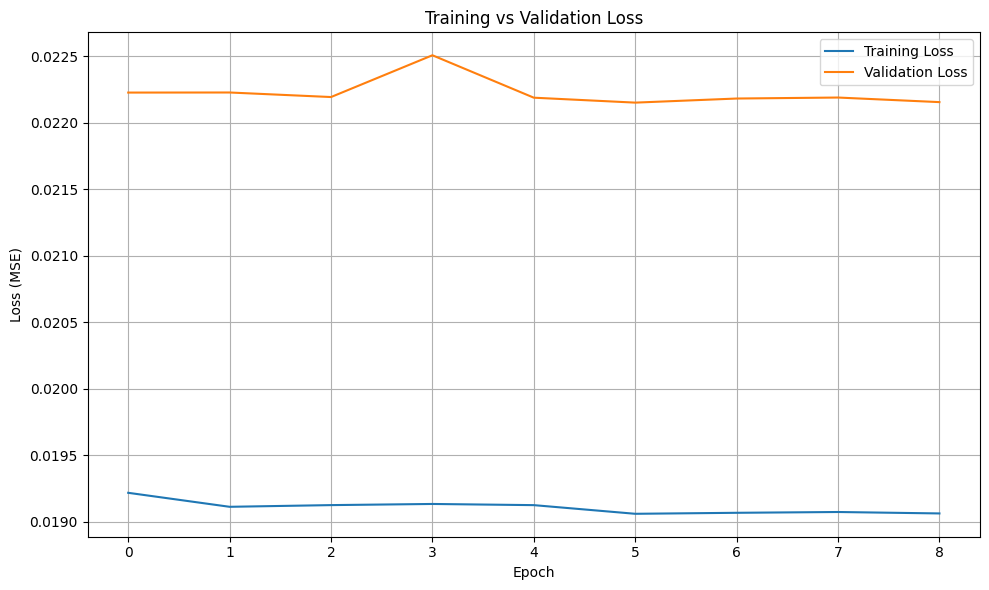

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()
y_true = y_test.flatten()



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 227s 91ms/step


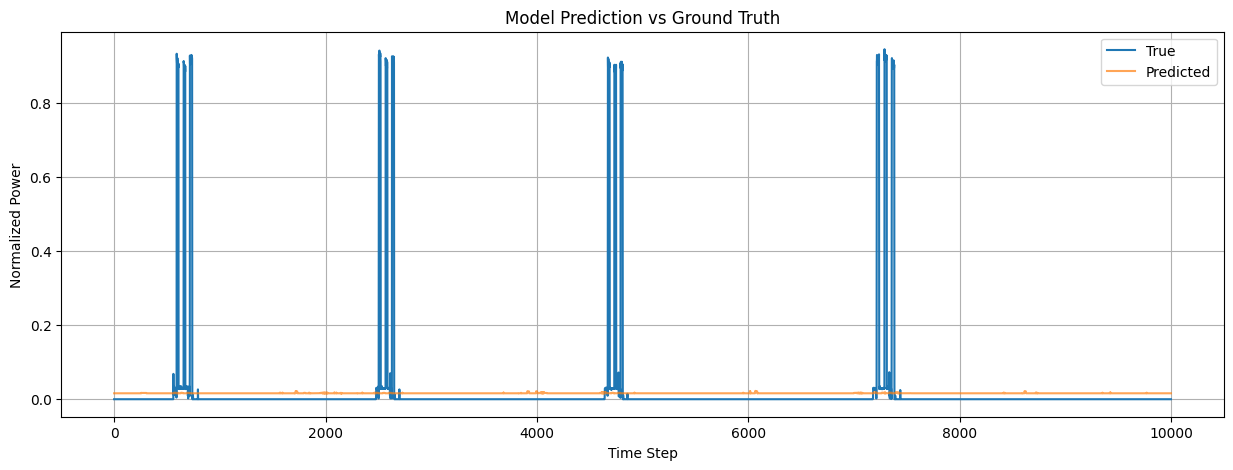

In [ ]:
start_index = 0
num_points = 10000

end_index = start_index + num_points
x = range(start_index, start_index + len(y_true[start_index:end_index]))

plt.figure(figsize=(15, 5))
plt.plot(x, y_true[start_index:end_index], label='True')
plt.plot(x, y_pred[start_index:end_index], label='Predicted', alpha=0.7)
plt.title("Model Prediction vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Normalized Power")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_norm = mean_absolute_error(y_true, y_pred)
print(f"MAE (normalized units): {mae_norm:.4f}")


agg_scaler = scalers["Aggregate"]          # the scaler you used for Aggregate
y_pred_watts = agg_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_watts = agg_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

mae_watts = mean_absolute_error(y_true_watts, y_pred_watts)
print(f"MAE (real scale): {mae_watts:.2f} W")

MAE (normalized units): 0.0371
MAE (real scale): 912.23 W
